#### Install the dependencies

In [172]:
# ! pip install langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python langchain-groq

In [173]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.schema import Document

#### Enter GROQ API Key

In [174]:
import os

os.environ["GROQ_API_KEY"] = "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"
os.environ['TAVILY_API_KEY'] = "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"

#### Load Connection to LLM


In [175]:
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

#### Download data

In [176]:
# Data related with Agents, Prompt Engineering and LLMs

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=10
)
doc_splits = text_splitter.split_documents(docs_list)

for ind, doc in enumerate(doc_splits):
    doc.metadata['chunk_id'] = ind  # Assign chunk_id

In [177]:
len(doc_splits)

497

In [178]:
doc_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

#### Use a Sentence-Transformer model

In [179]:
embedding_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

#### Create Vector Index

In [180]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def print_results(docs):
    for doc in docs[:5]:
        print(f"Chunk ID: {doc.metadata['chunk_id']}")
        print(doc.page_content.replace("\n", " "))
        print("-"*500)

In [181]:
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know.
            Do not make up the answer unless it is there in the provided context.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """

prompt_template = ChatPromptTemplate.from_template(prompt)

# Chain
rag_chain = prompt_template | llm | StrOutputParser()

In [182]:
from chromadb import PersistentClient

try:
    client = PersistentClient(path="./chroma_db")
    client.delete_collection("rag-chroma")
except:
    pass

In [183]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embedding_model,
    persist_directory="./chroma_db"
)


#### Question

In [184]:
question = "When was the research paper: Attention Is All You Need was pubilshed?"


#### Simple Retriever

In [185]:
num_docs_to_retrieve = 2

In [186]:
simple_retriever = vectorstore.as_retriever(search_type="similarity",
                                                search_kwargs={"k": num_docs_to_retrieve})

In [187]:
relevant_filter = EmbeddingsFilter(embeddings=embedding_model, similarity_threshold=0.5)
retriever = ContextualCompressionRetriever(
    base_compressor=relevant_filter, base_retriever=simple_retriever
)

In [188]:
docs = retriever.invoke(question)
len(docs)

0

#### RAG output

In [189]:
docs = format_docs(docs)

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

I don't know.


#### web_search_tool

In [190]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

##### Agent

In [191]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    node_visited: List[str]

In [192]:

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)

    state["documents"] = documents
    state["node_visited"] = ["retrieve_node"]
    return state


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})

    state["node_visited"].append("generate_node")
    state["generation"] = generation
    return state


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    if len(documents) < num_docs_to_retrieve:
        web_search = "Yes"
    else:
        web_search = "No"

    state["node_visited"].append("grade_documents_node")
    state["web_search"] = web_search

    return state

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke(question)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    state["node_visited"].append("web_search_node")
    state["documents"] = documents

    return state


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: WEB SEARCH---"
        )
        return "web_search_node"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate_node"

In [193]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve_node", retrieve)  # retrieve
workflow.add_node("grade_documents_node", grade_documents)  # grade documents
workflow.add_node("generate_node", generate)  # generatae
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve_node")
workflow.add_edge("retrieve_node", "grade_documents_node")
workflow.add_conditional_edges(
    "grade_documents_node",
    decide_to_generate,
    {
        "web_search_node": "web_search_node",
        "generate_node": "generate_node",
    },
)
workflow.add_edge("web_search_node", "generate_node")
workflow.add_edge("generate_node", END)

# Compile
app = workflow.compile()

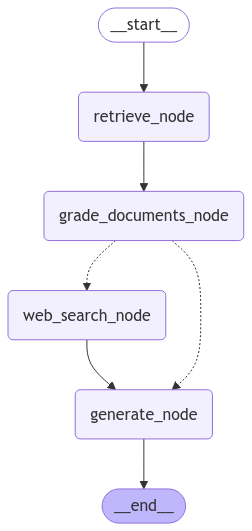

In [194]:
app

In [195]:
inputs = {'question': 'When was the research paper: Attention Is All You Need was pubilshed?'}

In [196]:
final_ouput = app.invoke(inputs)

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: WEB SEARCH---
---WEB SEARCH---
---GENERATE---


In [197]:
final_ouput['generation']

'The research paper "Attention Is All You Need" was published in 2017.'

In [198]:
final_ouput['node_visited']

['retrieve_node', 'grade_documents_node', 'web_search_node', 'generate_node']

In [199]:
inputs = {'question': 'What are the types of agent memory?'}

In [200]:
final_ouput = app.invoke(inputs)

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


In [201]:
final_ouput['generation']

'The types of agent memory mentioned in the context are:\n\n1. Short-term memory: This is utilized for in-context learning, where the model learns from the input context.\n2. Long-term memory: This provides the agent with the capability to retain and recall information over extended periods, often by leveraging an external vector store and fast retrieval.'

In [202]:
final_ouput['node_visited']

['retrieve_node', 'grade_documents_node', 'generate_node']